In [1]:
import psycopg2
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks", color_codes=True)
import matplotlib
import warnings
import yellowbrick as yb
matplotlib.style.use('ggplot')
import numpy as np
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("LasVegas.csv", sep=';')

In [3]:
df

,User country,Nr. reviews,Nr. hotel reviews,Helpful votes,Score,Period of stay,Traveler type,Pool,Gym,Tennis court,Spa,Casino,Free internet,Hotel name,Hotel stars,Nr. rooms,User continent,Member years,Review month,Review weekday
0,USA,11,4,13,5,Dec-Feb,Friends,NO,YES,NO,NO,YES,YES,Circus Circus Hotel & Casino Las Vegas,3,3773,North America,9,January,Thursday
1,USA,119,21,75,3,Dec-Feb,Business,NO,YES,NO,NO,YES,YES,Circus Circus Hotel & Casino Las Vegas,3,3773,North America,3,January,Friday
2,USA,36,9,25,5,Mar-May,Families,NO,YES,NO,NO,YES,YES,Circus Circus Hotel & Casino Las Vegas,3,3773,North America,2,February,Saturday
3,UK,14,7,14,4,Mar-May,Friends,NO,YES,NO,NO,YES,YES,Circus Circus Hotel & Casino Las Vegas,3,3773,Europe,6,February,Friday
4,Canada,5,5,2,4,Mar-May,Solo,NO,YES,NO,NO,YES,YES,Circus Circus Hotel & Casino Las Vegas,3,3773,North America,7,March,Tuesday
5,Canada,31,8,27,3,Mar-May,Couples,NO,YES,NO,NO,YES,YES,Circus Circus Hotel & Casino Las Vegas,3,3773,North America,2,March,Tuesday
6,UK,45,12,46,4,Mar-May,Couples,NO,YES,NO,NO,YES,YES,Circus Circus Hotel & Casino Las Vegas,3,3773,Europe,4,April,Friday
7,USA,2,1,4,4,Mar-May,Families,NO,YES,NO,NO,YES,YES,Circus Circus Hotel & Casino Las Vegas,3,3773,North America,0,April,Tuesday
8,India,24,3,8,4,Mar-May,Friends,NO,YES,NO,NO,YES,YES,Circus Circus Hotel & Casino Las Vegas,3,3773,Asia,3,May,Saturday
9,Canada,12,7,11,3,Mar-May,Families,NO,YES,NO,NO,YES,YES,Circus Circus Hotel & Casino Las Vegas,3,3773,North America,5,May,Tuesday


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 504 entries, 0 to 503
Data columns (total 20 columns):
User country         504 non-null object
Nr. reviews          504 non-null int64
Nr. hotel reviews    504 non-null int64
Helpful votes        504 non-null int64
Score                504 non-null int64
Period of stay       504 non-null object
Traveler type        504 non-null object
Pool                 504 non-null object
Gym                  504 non-null object
Tennis court         504 non-null object
Spa                  504 non-null object
Casino               504 non-null object
Free internet        504 non-null object
Hotel name           504 non-null object
Hotel stars          504 non-null object
Nr. rooms            504 non-null int64
User continent       504 non-null object
Member years         504 non-null int64
Review month         504 non-null object
Review weekday       504 non-null object
dtypes: int64(6), object(14)
memory usage: 78.9+ KB


In [5]:
#identify  any null values
null_columns=df.columns[df.isnull().any()]
df[null_columns].isnull().sum()

Series([], dtype: float64)

In [6]:
df['Score'].value_counts() 

5    227
4    164
3     72
2     30
1     11
Name: Score, dtype: int64

In [7]:
df['Gym'].value_counts() 

YES    480
NO      24
Name: Gym, dtype: int64

In [8]:
df['Spa'].value_counts() 

YES    384
NO     120
Name: Spa, dtype: int64

In [9]:
#set color scheme
sns.set_palette("cubehelix")

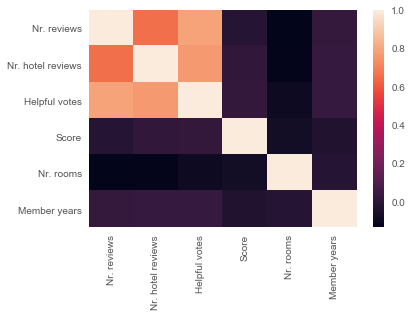

In [10]:
sns.heatmap(df.corr())

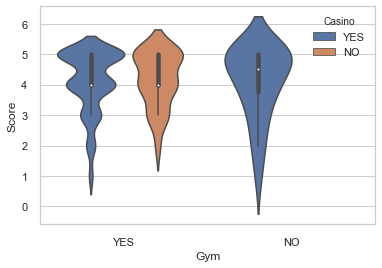

In [11]:
sns.set(style="whitegrid")
sns.violinplot(x="Gym", y="Score", hue="Casino", data=df, figsize = (15,15))

In [12]:
corr_matrix = df.corr()
corr_matrix['Score'].sort_values(ascending=False)

Score                1.000000
Helpful votes        0.015472
Nr. hotel reviews    0.013718
Nr. reviews         -0.024320
Member years        -0.036190
Nr. rooms           -0.080200
Name: Score, dtype: float64

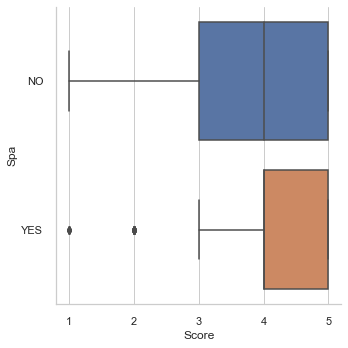

In [13]:
sns.catplot(x='Score', y='Spa', kind="box", data=df);

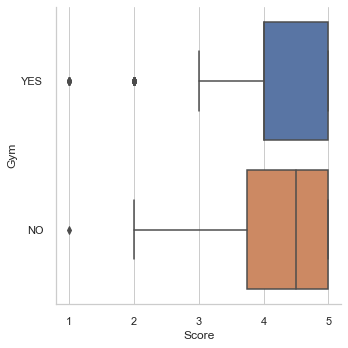

In [14]:
sns.catplot(x='Score', y='Gym', kind="box", data=df);

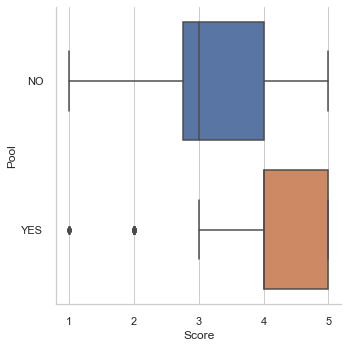

In [15]:
sns.catplot(x='Score', y='Pool', kind="box", data=df);

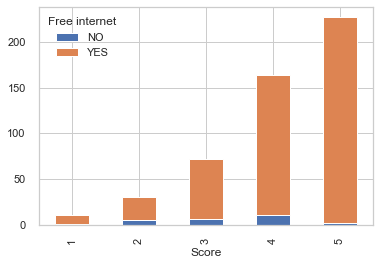

In [16]:
#check score vs. casino
df.groupby(['Score','Free internet']).size().unstack().plot(kind='bar',stacked=True)
plt.show()

In [17]:
LABEL_MAP = {
"YES": 1,
"NO": 0
}
# Convert categorical labels into incremental value
df['Pool'] = df['Pool'].map(LABEL_MAP).to_frame()
df['Gym'] = df['Gym'].map(LABEL_MAP).to_frame()
df['Tennis court'] = df['Tennis court'].map(LABEL_MAP).to_frame()
df['Spa'] = df['Spa'].map(LABEL_MAP).to_frame()
df['Free internet'] = df['Free internet'].map(LABEL_MAP).to_frame()
df['Casino'] = df['Casino'].map(LABEL_MAP).to_frame()

In [18]:
df = df.drop(columns=['User continent', 'User country', 'Period of stay', 'Traveler type', 'Hotel name', 'Hotel stars',
            'Review month', 'Review weekday'])



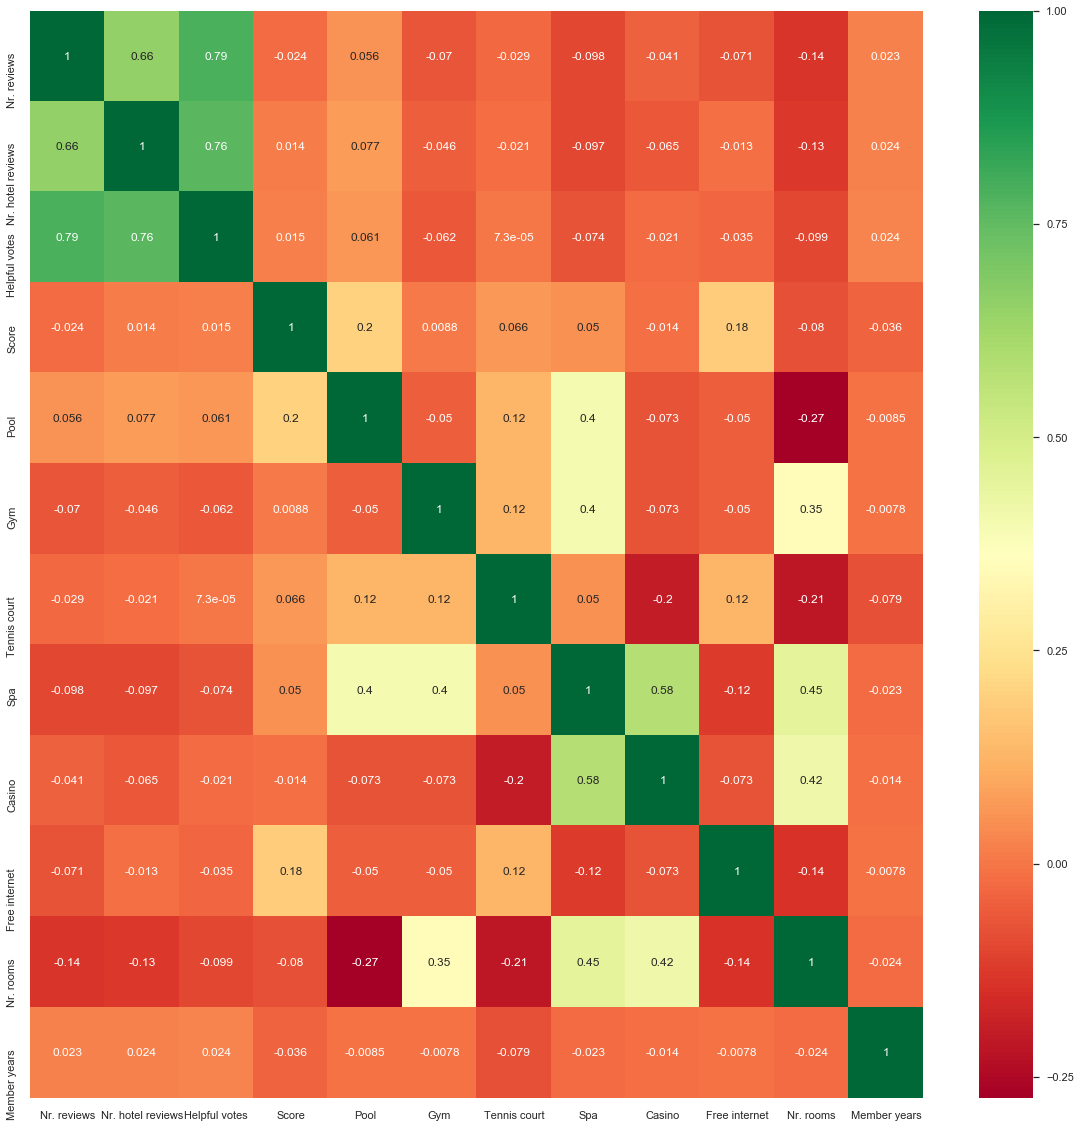

In [19]:
corrmat = df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [20]:
y = df['Score']
X = df.loc[:, df.columns.difference(['Score'])]


In [21]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 33)

/Users/sabashaikh/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


/Users/sabashaikh/anaconda2/envs/py36/lib/python3.6/site-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


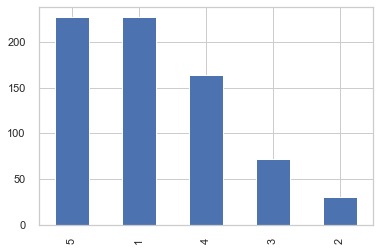

In [22]:
X_sm, y_sm = sm.fit_sample(X, y.ravel())
pd.Series(y_sm).value_counts().plot.bar()

/Users/sabashaikh/anaconda2/envs/py36/lib/python3.6/site-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


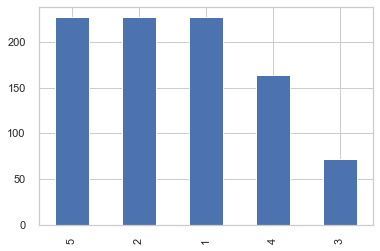

In [23]:
X_sm, y_sm = sm.fit_sample(X_sm, y_sm.ravel())
pd.Series(y_sm).value_counts().plot.bar()

/Users/sabashaikh/anaconda2/envs/py36/lib/python3.6/site-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


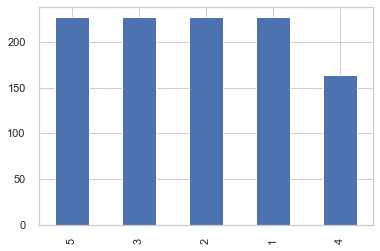

In [24]:
X_sm, y_sm = sm.fit_sample(X_sm, y_sm.ravel())
pd.Series(y_sm).value_counts().plot.bar()

/Users/sabashaikh/anaconda2/envs/py36/lib/python3.6/site-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


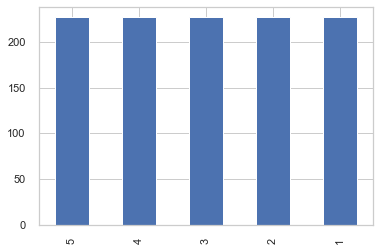

In [25]:
X_sm, y_sm = sm.fit_sample(X_sm, y_sm.ravel())
pd.Series(y_sm).value_counts().plot.bar()

In [26]:
# Create the train and test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_sm, y_sm, test_size=0.2)

In [27]:
def score_model(X, y, estimator, **kwargs):

    y = LabelEncoder().fit_transform(y)

    model = Pipeline([
         ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore')), 
         ('estimator', estimator)
    ])

    model.fit(X_train, y_train, **kwargs)  
    
    expected  = y_test
    predicted = model.predict(X_test)
    
    # Compute and return F1 (harmonic mean of precision and recall)
    print("{}: {}".format(estimator.__class__.__name__, f1_score(expected, predicted, average='micro')))

In [28]:
models = [
    SVC(), 
    #NuSVC(), 
    LinearSVC(), 
    SGDClassifier(), KNeighborsClassifier(), 
    LogisticRegression(), 
    #aggingClassifier(), 
    ExtraTreesClassifier(n_estimators=100), 
    RandomForestClassifier(n_estimators=100),
    GradientBoostingClassifier(n_estimators=100,learning_rate=.3)
    #learning_rate=.5,max_depth=4, min_samples_leaf=75
]

for model in models:
    score_model(X_train, y_train, model)

/Users/sabashaikh/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC: 0.14096916299559473
LinearSVC: 0.4801762114537445
SGDClassifier: 0.4801762114537445
KNeighborsClassifier: 0.30837004405286345


/Users/sabashaikh/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/sabashaikh/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression: 0.4933920704845815
ExtraTreesClassifier: 0.5726872246696035
RandomForestClassifier: 0.5374449339207048
GradientBoostingClassifier: 0.4581497797356828
